##  **Dataset Source**

We used the [CyberBERT Dataset](https://huggingface.co/datasets/agrawalchaitany/cyberbert_dataset), which is publicly available on Hugging Face .

###  Description:
* The dataset contains a wide range of **network traffic features** used for **cybersecurity threat detection**.
* It includes both **normal (BENIGN)** traffic and **various attack types** such as DoS, PortScan, DDoS, and more.
* Each row represents a network flow with detailed statistical features (e.g., packet length, flow duration, header size).

###  Access Method:
* We loaded the dataset directly using the  `datasets` library in Python:
```python
from datasets import load_dataset
dataset = load_dataset("agrawalchaitany/cyberbert_dataset")

In [69]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model

from sklearn.metrics import f1_score, precision_score, recall_score


dataset = load_dataset("agrawalchaitany/cyberbert_dataset")

# **1. Data Handling**



## Data Cleaning and Preprocessing




In [70]:
df = dataset['train'].to_pandas()
pd.set_option('display.max_columns', None)

df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,33.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,29411.764710,29411.764710,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,31.0,329.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,32.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


###  Feature Categorization

We divided the dataset features into four types:

1. **Binary Columns**  
   ➤ Already encoded with 0 and 1 — ready for use in modeling.

2. **Multiclass Categorical Columns**  
   ➤ Represent categories like port numbers or labels.  
   ➤ Will be encoded .

3. **Continuous Columns**  
   ➤ Numerical features with wide value ranges.  
   ➤ Will be scaled (e.g., log + robust scaling) before training.

4. **Single-Class Columns**  
   ➤ Have the same value in all rows — to be removed.

This categorization helps decide:
- What to **encode**  
- What to **scale**  
- What to **drop**

In [71]:
"""
This block of code categorizes features into four types:

1. Binary Columns:
   ➤ Columns with only two unique values, typically 0 and 1.

2. Multiclass Categorical Columns:
   ➤ Columns that contain multiple distinct categories, 
     usually represented as integers or strings.
     Examples include 'Label' and 'Destination Port', 
     which represent class IDs or protocol categories — not true continuous values.

3. Continuous Columns:
   ➤ Features with high cardinality and continuous numeric values.

4. Single-Class Columns:
   ➤ Columns that contain the same value across all rows
     and therefore provide no information — often removed later.
"""

binary_cols = []
multiclass_categorical_cols = []
continuous_cols = []
single_class_cols = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    num_unique = len(unique_vals)
    dtype = df[col].dtype

    if num_unique <= 1:
        # ➤ Column with constant/single class value
        single_class_cols.append(col)

    elif col == 'Destination Port':
        # ➤ Force classify 'Destination Port' as Multiclass Categorical
        multiclass_categorical_cols.append(col)

    elif dtype in ['int64', 'float64']:
        if num_unique == 2 and set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
        elif num_unique <= 15:
            multiclass_categorical_cols.append(col)
        else:
            continuous_cols.append(col)
    else:
        multiclass_categorical_cols.append(col)

print(f" Binary Columns: {binary_cols}")
print(f" Multiclass Categorical Columns: {multiclass_categorical_cols}")
print(f" Continuous Columns: {continuous_cols}")
print(f"Single-Class (Constant) Columns: {single_class_cols}")

 Binary Columns: ['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count']
 Multiclass Categorical Columns: ['Destination Port', 'Label']
 Continuous Columns: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mea

In [72]:
"""
 Encoding Destination Port:

The 'Destination Port' feature has a **high number of unique values**, 
which makes it unsuitable to treat as a continuous numerical feature.

➤ Instead of using it directly, we extracted only the most important/common ports 
   based on known networking standards and attack patterns.

Examples:
- Port 80  → HTTP (web traffic)
- Port 443 → HTTPS (secure web traffic)
- Port 22  → SSH (remote shell access)
- Port 53  → DNS (domain resolution)
- Port 25  → SMTP (email sending)
- Port 3306 → MySQL database
- Port 3389 → Remote Desktop Protocol

➤ All other uncommon or rare ports were grouped under the label 'other'.

➤ We then applied one-hot encoding to represent each port as a separate binary feature (0 or 1),
   allowing models to distinguish connections based on known port activity while 
   avoiding the noise of less relevant or random ports.
"""

important_ports = [21, 22, 23, 25, 53, 80, 110, 111, 135, 139,
                   143, 443, 445, 993, 995, 1723, 3306, 3389, 5900, 8080]

df['Destination Port Encoded'] = df['Destination Port'].apply(
    lambda x: x if x in important_ports else 'other'
)

port_dummies = pd.get_dummies(df['Destination Port Encoded'], prefix='Port').astype(int)

df = pd.concat(
    [df.drop(columns=['Destination Port', 'Destination Port Encoded']), port_dummies],
    axis=1
)


#  Let's preview the new port features:
print(" New Port Features:", port_dummies.columns.tolist())
df[port_dummies.columns].head()

 New Port Features: ['Port_21.0', 'Port_22.0', 'Port_23.0', 'Port_25.0', 'Port_53.0', 'Port_80.0', 'Port_110.0', 'Port_111.0', 'Port_135.0', 'Port_139.0', 'Port_143.0', 'Port_443.0', 'Port_445.0', 'Port_993.0', 'Port_995.0', 'Port_1723.0', 'Port_3306.0', 'Port_3389.0', 'Port_5900.0', 'Port_8080.0', 'Port_other']


,Port_21.0,Port_22.0,Port_23.0,Port_25.0,Port_53.0,Port_80.0,Port_110.0,Port_111.0,Port_135.0,Port_139.0,Port_143.0,Port_443.0,Port_445.0,Port_993.0,Port_995.0,Port_1723.0,Port_3306.0,Port_3389.0,Port_5900.0,Port_8080.0,Port_other
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [73]:
# Select only the continuous columns for correlation analysis
df_continuous_only = df[continuous_cols]

# Optional: expand display options for better view if needed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Compute correlation matrix on continuous features
correlation_matrix = df_continuous_only.corr()

# Show correlation matrix
correlation_matrix


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,1.000000,0.020571,0.019389,0.063509,0.015998,0.263401,-0.115716,0.134033,0.224957,0.485858,-0.238692,0.448503,0.433671,-0.024982,-0.109900,0.534831,0.734884,0.779979,0.060566,0.998529,0.543119,0.721063,0.779716,0.209850,0.819887,0.408650,0.517722,0.580336,0.212795,-0.000097,-0.001049,-0.099488,-0.080348,-0.247385,0.501514,0.417241,0.445197,0.271962,-0.165840,0.394800,0.134033,0.448503,-0.000097,0.020571,0.063592,0.019389,0.015998,0.094089,-0.034352,0.015728,-0.001236,0.184985,0.238497,0.289933,0.117259,0.764124,0.240369,0.775744,0.734123
Total Fwd Packets,0.020571,1.000000,0.999070,0.365510,0.996993,0.009071,-0.003255,-0.000262,0.001110,0.022552,-0.006068,0.021123,0.006045,0.000391,-0.002342,-0.001366,-0.000954,0.001862,-0.000589,0.020240,-0.001361,-0.000333,0.001418,-0.001290,0.023794,-0.000883,0.000475,0.003095,-0.001144,0.000476,0.013750,-0.002132,-0.001655,-0.006792,0.021735,0.024239,0.011654,0.005141,0.000882,0.021865,-0.000262,0.021123,0.000476,1.000000,0.365992,0.999070,0.996987,0.003729,-0.000658,0.887386,-0.000181,0.039822,0.008207,0.030318,0.041186,0.001402,0.000676,0.001483,0.001266
Total Backward Packets,0.019389,0.999070,1.000000,0.359457,0.994430,0.008764,-0.002834,-0.000617,0.000743,0.022342,-0.005343,0.021244,0.005722,0.000335,-0.002383,-0.001711,-0.001426,0.001406,-0.000615,0.019040,-0.001541,-0.000860,0.000947,-0.001160,0.023219,-0.001039,0.000272,0.003177,-0.001100,0.000757,0.013766,-0.002231,-0.001369,-0.006152,0.021469,0.024655,0.011508,0.005111,0.003279,0.022290,-0.000617,0.021244,0.000757,0.999070,0.359939,1.000000,0.994424,0.003167,-0.000660,0.882566,0.000021,0.038853,0.006318,0.028465,0.041185,0.001020,0.000364,0.001045,0.000938
Total Length of Fwd Packets,0.063509,0.365510,0.359457,1.000000,0.353781,0.196242,-0.001737,0.185073,0.158876,0.020773,-0.027818,0.016485,0.007706,0.002270,-0.011863,0.002748,0.012694,0.024882,-0.003042,0.062692,0.004294,0.021239,0.024958,-0.006131,0.076069,0.006502,0.035046,0.040385,-0.005122,-0.001338,0.005022,-0.010602,-0.009385,-0.028487,0.074798,0.081365,0.057367,0.033850,-0.011819,0.076025,0.185073,0.016485,-0.001338,0.365510,0.999999,0.359457,0.353788,0.030642,0.010016,0.407471,-0.001193,0.100416,0.102761,0.125756,0.067749,0.020631,0.026406,0.024051,0.016646
Total Length of Bwd Packets,0.015998,0.996993,0.994430,0.353781,1.000000,0.006409,-0.002356,-0.001661,-0.000685,0.021829,-0.004263,0.020545,0.005771,0.000529,-0.001673,-0.001636,-0.001482,0.000834,-0.000427,0.015683,-0.001521,-0.001021,0.000383,-0.000939,0.018959,-0.001304,-0.000655,0.001733,-0.000923,0.000751,0.013691,-0.001557,-0.001012,-0.004903,0.020710,0.023301,0.011029,0.005736,0.002942,0.021152,-0.001661,0.020545,0.000751,0.996993,0.354261,0.994430,1.000000,0.001239,-0.000759,0.883966,0.000020,0.035881,0.003404,0.024741,0.039005,0.000507,0.000010,0.000491,0.000498
Fwd Packet Length Max,0.263401,0.009071,0.008764,0.196242,0.006409,1.000000,-0.004279,0.888881,0.968528,0.084652,-0.141937,0.064390,0.066017,0.036177,-0.05556

In [74]:
def get_perfect_correlations(corr_matrix):
    """
    Given a correlation matrix, find all pairs of features with perfect correlation (1.0)
    excluding self-correlations.
    """
    perfect_corr_pairs = []

    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 != col2 and corr_matrix.loc[col1, col2] == 1.0:
                pair = tuple(sorted((col1, col2)))
                perfect_corr_pairs.append(pair)

    # Remove duplicates
    unique_pairs = list(set(perfect_corr_pairs))

    # Format results
    result_df = pd.DataFrame(unique_pairs, columns=["Feature 1", "Feature 2"])
    result_df["Correlation"] = 1.0

    print(f"Found {len(result_df)} perfect correlations (corr = 1.0)")
    return result_df


get_perfect_correlations(correlation_matrix)

Found 4 perfect correlations (corr = 1.0)


,Feature 1,Feature 2,Correlation
0,Fwd Header Length,Fwd Header Length.1,1.0
1,Subflow Fwd Packets,Total Fwd Packets,1.0
2,Subflow Bwd Packets,Total Backward Packets,1.0
3,Avg Fwd Segment Size,Fwd Packet Length Mean,1.0


In [75]:


"""
Checking for exact equality between pairs of features that showed perfect correlation (1.0).
This step helps verify whether the features are truly duplicates (identical values row by row)
or just mathematically correlated (e.g., multiples or derived values).
If the result is True, the features are completely identical and one of them can be safely dropped.
"""


print(" Subflow Bwd Packets == Total Backward Packets:", 
      (df['Subflow Bwd Packets'] == df['Total Backward Packets']).all())


print(" Fwd PSH Flags == SYN Flag Count:", 
      (df['Fwd PSH Flags'] == df['SYN Flag Count']).all())

print("CWE Flag Count == Fwd URG Flags:", 
      (df['CWE Flag Count'] == df['Fwd URG Flags']).all())

print(" Subflow Fwd Packets == Total Fwd Packets:", 
      (df['Subflow Fwd Packets'] == df['Total Fwd Packets']).all())


print(" Fwd Header Length == Fwd Header Length.1:", 
      (df['Fwd Header Length'] == df['Fwd Header Length.1']).all())


print(" Avg Fwd Segment Size == Fwd Packet Length Mean:", 
      (df['Avg Fwd Segment Size'] == df['Fwd Packet Length Mean']).all())

 Subflow Bwd Packets == Total Backward Packets: True
 Fwd PSH Flags == SYN Flag Count: True
CWE Flag Count == Fwd URG Flags: True
 Subflow Fwd Packets == Total Fwd Packets: True
 Fwd Header Length == Fwd Header Length.1: True
 Avg Fwd Segment Size == Fwd Packet Length Mean: False


In [76]:
#  Inspecting bulk-related features to verify if they carry useful information

bulk_columns = [
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
]

for col in bulk_columns:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(dropna=False))

"""
All of these bulk-related columns contain only zeros or NaN values.
➤ They offer no variance or discriminative information for the model.
➤ We will drop them to simplify the dataset and improve model efficiency.
"""


Value counts for 'Fwd Avg Bytes/Bulk':
Fwd Avg Bytes/Bulk
0.0    2522362
Name: count, dtype: int64

Value counts for 'Fwd Avg Packets/Bulk':
Fwd Avg Packets/Bulk
0.0    2522362
Name: count, dtype: int64

Value counts for 'Fwd Avg Bulk Rate':
Fwd Avg Bulk Rate
0.0    2522362
Name: count, dtype: int64

Value counts for 'Bwd Avg Bytes/Bulk':
Bwd Avg Bytes/Bulk
0.0    2522362
Name: count, dtype: int64

Value counts for 'Bwd Avg Packets/Bulk':
Bwd Avg Packets/Bulk
0.0    2522362
Name: count, dtype: int64

Value counts for 'Bwd Avg Bulk Rate':
Bwd Avg Bulk Rate
0.0    2522362
Name: count, dtype: int64


'\nAll of these bulk-related columns contain only zeros or NaN values.\n➤ They offer no variance or discriminative information for the model.\n➤ We will drop them to simplify the dataset and improve model efficiency.\n'

### **Dealing with nagative values**



After exploring the dataset, we found that some numeric features contained negative values, which are logically incorrect in this context—such as negative time durations, speeds, or packet sizes. These values were mostly found in the `BENIGN` class, which dominates the dataset with over 2 million samples.

To ensure clean and reliable data, we decided to remove all rows that had negative values in the following columns:
`Flow Duration`, `Flow Bytes/s`, `Flow Packets/s`, `Flow IAT Mean`, `Flow IAT Max`, `Flow IAT Min`, `Fwd IAT Min`, `Fwd Header Length`, `Bwd Header Length`, and `min_seg_size_forward`.

For the column `Init_Win_bytes_forward`, we observed that more than 99% of its negative values appeared only in benign traffic. This made it non-informative and noisy for classification, so we removed both its negative rows and the column itself.

However, we kept the column `Init_Win_bytes_backward` because its negative values were more meaningfully distributed across both benign and attack labels—particularly DoS and DDoS attacks. We believe this variation might help the model learn useful patterns related to malicious activity.

In [77]:
def identify_negative_values(df):
    """
    Identify and report negative values in numeric columns.
    This function helps in understanding which columns contain invalid negative values,
    and whether these values are concentrated in specific classes (e.g., BENIGN vs. ATTACK).
    """
    negative_counts = {}

    for col in df.select_dtypes(include='number').columns:
        count = (df[col] < 0).sum()
        if count > 0:
            negative_counts[col] = count

    print("\nNegative Value Counts:")
    for col, count in negative_counts.items():
        print(f"{col}: {count}")

    # Manually defined columns where negative values are not expected
    negative_cols = [
        'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
        'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
        'Fwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'min_seg_size_forward'
    ]

    for col in negative_cols:
        print(f"\nColumn: '{col}'")
        negative_rows = df[df[col] < 0]
        print(f"Total negative values: {len(negative_rows)}")

        if not negative_rows.empty:
            label_dist = negative_rows['Label'].value_counts()
            for label, count in label_dist.items():
                print(f"   {label}: {count}")
        else:
            print("   No negative values found.")

identify_negative_values(df)


Negative Value Counts:
Flow Duration: 107
Flow Bytes/s: 78
Flow Packets/s: 107
Flow IAT Mean: 107
Flow IAT Max: 107
Flow IAT Min: 2881
Fwd IAT Min: 17
Fwd Header Length: 35
Bwd Header Length: 22
Fwd Header Length.1: 35
Init_Win_bytes_forward: 911027
Init_Win_bytes_backward: 1216341
min_seg_size_forward: 35

Column: 'Flow Duration'
Total negative values: 107
   BENIGN: 107

Column: 'Flow Bytes/s'
Total negative values: 78
   BENIGN: 78

Column: 'Flow Packets/s'
Total negative values: 107
   BENIGN: 107

Column: 'Flow IAT Mean'
Total negative values: 107
   BENIGN: 107

Column: 'Flow IAT Max'
Total negative values: 107
   BENIGN: 107

Column: 'Flow IAT Min'
Total negative values: 2881
   BENIGN: 2688
   DoS Hulk: 158
   DDoS: 19
   DoS GoldenEye: 5
   FTP-Patator: 4
   Heartbleed: 4
   SSH-Patator: 2
   Infiltration: 1

Column: 'Fwd IAT Min'
Total negative values: 17
   DoS Hulk: 8
   DDoS: 6
   DoS GoldenEye: 3

Column: 'Fwd Header Length'
Total negative values: 35
   BENIGN: 35

Colum

In [78]:
# Define the columns where negative values are considered invalid
columns_to_clean = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'min_seg_size_forward'
]

# Remove rows that contain negative values in any of these columns
df = df[~(df[columns_to_clean] < 0).any(axis=1)]

In [79]:

"""
 Decision:

We decided to remove the column 'Init_Win_bytes_forward' because:
- Over 99% of its negative values occur in BENIGN traffic only.
- It does not help distinguish between normal and attack traffic.
- It adds noise and unnecessary complexity to the model without contributing valuable information.

On the other hand, we chose to keep  the column 'Init_Win_bytes_backward' because:
- Although it also contains many negative values, these appear across both BENIGN and various attack types.
- This variation may provide useful signals for classification, especially in detecting DoS and DDoS behaviors.
"""


cols_to_check = ['Init_Win_bytes_forward', 'Init_Win_bytes_backward']

for col in cols_to_check:
    print("="*60)
    print(f" Column: '{col}' — Negative Values per Label:")
    
    neg_rows = df[df[col] < 0]
    print(neg_rows['Label'].value_counts())

 Column: 'Init_Win_bytes_forward' — Negative Values per Label:
Label
BENIGN      910969
PortScan         7
Name: count, dtype: int64
 Column: 'Init_Win_bytes_backward' — Negative Values per Label:
Label
BENIGN              1153016
DDoS                  46524
DoS Hulk               9234
DoS Slowhttptest       3145
DoS GoldenEye          2572
DoS slowloris          1639
PortScan                 64
FTP-Patator              64
Web Attack � XSS         17
SSH-Patator              12
Infiltration              3
Name: count, dtype: int64


## Removed Features


In [80]:
# Dropping the column 'Fwd Header Length.1' because it's a duplicate of 'Fwd Header Length'
# It was automatically created when the dataset had two columns with the same name
df.drop(columns=['Fwd Header Length.1'], inplace=True)

# Dropping the column 'Avg Fwd Segment Size' because it has almost identical values to 'Fwd Packet Length Mean'
# Keeping both would be redundant, so we keep only one to reduce feature duplication
df.drop(columns=['Avg Fwd Segment Size'], inplace=True)

# Dropping bulk-related columns because all their values are zero,
df.drop(columns=bulk_columns, inplace=True)


# Dropping 'Bwd PSH Flags' column because it contains only zero or NaN values.
# From both a data and domain perspective, it provides no variance and no distinguishing signal
# between normal and attack traffic.

df.drop(columns=['Bwd PSH Flags'], inplace=True)


# Dropping Bwd URG Flags columns because all their values are zero,
df.drop(columns=['Bwd URG Flags'], inplace=True)


"""
Removing rows that contain NaN or infinite values in 'Flow Bytes/s' or 'Flow Packets/s'.
We checked the label distribution for these rows and found that most of them (1427 out of ~1500)
belong to the 'BENIGN' class, which is the dominant class in the dataset.
Considering the class imbalance, this removal does not significantly affect minority attack classes,
and helps clean up invalid values that could negatively impact model performance.
"""

df = df[
    ~df["Flow Bytes/s"].isin([np.inf, -np.inf]) &
    ~df["Flow Packets/s"].isin([np.inf, -np.inf]) &
    df["Flow Bytes/s"].notna() &
    df["Flow Packets/s"].notna()
]

# Dropping perfectly correlated features based on correlation = 1.0.
# These columns are either exact duplicates or carry redundant information.
# Subflow Bwd Packets is identical to Total Backward Packets
# Fwd PSH Flags has the same values as SYN Flag Count (unexpected, likely tool duplication)
# CWE Flag Count is the same as Fwd URG Flags (likely internal alias)
# Subflow Fwd Packets is identical to Total Fwd Packets
df.drop(columns=[
    'Subflow Bwd Packets',
    'Fwd PSH Flags',
    'CWE Flag Count',
    'Subflow Fwd Packets'
], inplace=True)

df.drop(columns=['Init_Win_bytes_forward'], inplace=True)


df.drop(columns=['Init_Win_bytes_backward'], inplace=True)

In [81]:
df['Label'].value_counts()

Label
BENIGN                        2092335
DoS Hulk                       172688
DDoS                           127995
PortScan                        90694
DoS GoldenEye                   10281
FTP-Patator                      5927
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3217
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       35
Web Attack � Sql Injection         21
Heartbleed                          7
Name: count, dtype: int64

In [82]:
print("Number of columns after cleaning:", df.shape[1])

Number of columns after cleaning: 83


In [83]:
identify_negative_values(df)


Negative Value Counts:

Column: 'Flow Duration'
Total negative values: 0
   No negative values found.

Column: 'Flow Bytes/s'
Total negative values: 0
   No negative values found.

Column: 'Flow Packets/s'
Total negative values: 0
   No negative values found.

Column: 'Flow IAT Mean'
Total negative values: 0
   No negative values found.

Column: 'Flow IAT Max'
Total negative values: 0
   No negative values found.

Column: 'Flow IAT Min'
Total negative values: 0
   No negative values found.

Column: 'Fwd IAT Min'
Total negative values: 0
   No negative values found.

Column: 'Fwd Header Length'
Total negative values: 0
   No negative values found.

Column: 'Bwd Header Length'
Total negative values: 0
   No negative values found.

Column: 'min_seg_size_forward'
Total negative values: 0
   No negative values found.


In [84]:
numeric_df = df.select_dtypes(include='number')


In [85]:
df['Label_binary'] = (df['Label'] != 'BENIGN').astype(int)

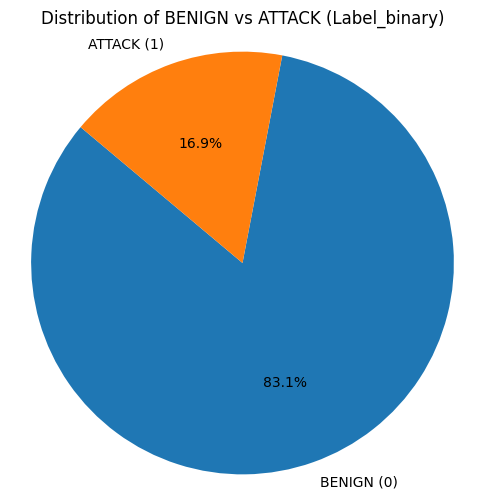

In [86]:

counts = df['Label_binary'].value_counts()


labels = ['BENIGN (0)', 'ATTACK (1)']

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of BENIGN vs ATTACK (Label_binary)')
plt.axis('equal')  
plt.show()

##  Step: Data Splitting & Label Setup

We first performed a standard split of the dataset into training, validation, and test sets. Then, we kept only the normal samples from the training set to train the model exclusively on normal behavior. For the test set, we combined both normal and attack samples and converted the labels into binary format: 0 for normal and 1 for any type of attack. This setup helps the model learn what normal data looks like and then evaluate its ability to detect anomalies during testing.

In [87]:


features = df.drop(columns=['Label', 'Label_binary'], errors='ignore')
labels = df['Label_binary']


train_data, test_data, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.03, random_state=42
)

In [88]:
train_data.shape

(2442346, 82)

In [89]:
print(test_labels.value_counts())

Label_binary
0    63060
1    12477
Name: count, dtype: int64


In [90]:


available_continuous_cols = [col for col in continuous_cols if col in train_data.columns]


for col in available_continuous_cols:
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])


scaler = RobustScaler()
train_data[available_continuous_cols] = scaler.fit_transform(train_data[available_continuous_cols])
test_data[available_continuous_cols] = scaler.transform(test_data[available_continuous_cols])

In [91]:
normal_train_data = train_data[train_labels == 0]
anomalous_train_data = train_data[train_labels == 1]



normal_test_data = test_data[test_labels == 0]
anomalous_test_data = test_data[test_labels == 1]


In [92]:
train_labels.head()

309908     1
1192122    0
1146768    0
2139990    1
659158     0
Name: Label_binary, dtype: int64

##  Model Construction & Training Setup


In [93]:


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

input_dim = normal_train_data.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128)(input_layer)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dense(64)(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dense(32)(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)

decoded = Dense(64)(encoded)
decoded = LeakyReLU(alpha=0.1)(decoded)
decoded = Dense(128)(decoded)
decoded = LeakyReLU(alpha=0.1)(decoded)

output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=RMSprop(learning_rate=0.0005), loss=Huber())

autoencoder.summary()

/Users/rahafmasmali/.pyenv/versions/3.10.13/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 82)             │        10,578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,970 (163.95 KB)

 Trainable params: 41,970 (163.95 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 33s 508us/step - loss: 0.0095 - val_loss: 0.0039
Epoch 2/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 502us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 3/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 504us/step - loss: 9.8910e-04 - val_loss: 0.0024
Epoch 4/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 501us/step - loss: 7.9997e-04 - val_loss: 0.0024
Epoch 5/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 503us/step - loss: 6.9311e-04 - val_loss: 0.0021
Epoch 6/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 504us/step - loss: 6.2179e-04 - val_loss: 0.0021
Epoch 7/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 503us/step - loss: 5.7037e-04 - val_loss: 0.0020
Epoch 8/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 504us/step - loss: 5.2996e-04 - val_loss: 0.0019
Epoch 9/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 501us/step - loss: 4.9747e-04 - val_loss: 0.0018
Epoch 10/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 501us/step - loss: 4.6873e-04 - val_loss: 0.0019
Epoch 11/20
63415/63415 ━━━━━━━━━━━━━

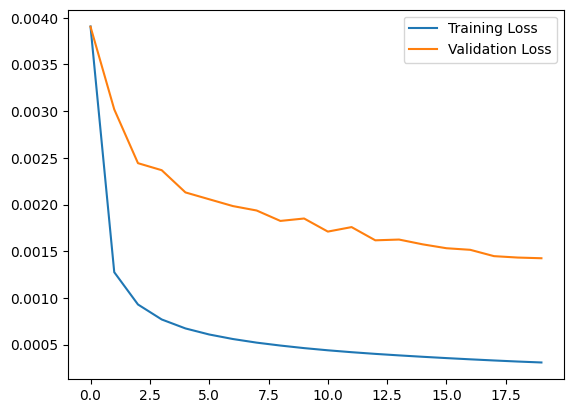

: 

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

##  Threshold Selection

We calculated the reconstruction loss on normal training data, then tested different thresholds using:

**threshold = mean(train_loss) + factor × std(train_loss)**

For each factor (0.5 to 4.0), we computed F1, precision, and recall.  
The best threshold was the one with the highest F1 score.

In [ ]:

reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data).numpy()


reconstructions_train = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data).numpy()


best_factor = None
best_f1 = 0

for factor in np.arange(0.5, 4.1, 0.1):
    threshold = np.mean(train_loss) + factor * np.std(train_loss)
    
    preds = (test_loss > threshold).astype(int)
    
    # نحسب F1 Score
    f1 = f1_score(test_labels, preds)
    precision = precision_score(test_labels, preds)
    recall = recall_score(test_labels, preds)

    print(f"Factor: {factor:.1f} | F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_factor = factor

print(f"\ Best Factor: {best_factor:.1f} --> Best F1 Score: {best_f1:.4f}")

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 14s 222us/step


In [ ]:

#autoencoder.save("model_80.99.h5")

In [ ]:
"""
autoencoder = load_model("model_80.99.h5")

reconstructions = autoencoder.predict(test_data)

test_loss = tf.keras.losses.mae(reconstructions, test_data).numpy()

reconstructions_train = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data).numpy()

factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)
print(f" Threshold using factor {factor}: {threshold:.5f}")

preds = (test_loss > threshold).astype(int)

print(" Evaluation on Test Set:")
print("Precision = {:.4f}".format(precision_score(test_labels, preds)))
print("Recall    = {:.4f}".format(recall_score(test_labels, preds)))
print("F1 Score  = {:.4f}".format(f1_score(test_labels, preds)))
"""

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 14s 226us/step
 Threshold using factor 1.8: 0.02535
 Evaluation on Test Set:
Precision = 0.7941
Recall    = 0.8263
F1 Score  = 0.8099


In [ ]:
"""
row = normal_train_data.iloc[0]

input_data = np.array(row, dtype=np.float32).reshape(1, -1)

reconstructed = autoencoder.predict(input_data)
loss = tf.keras.losses.mae(reconstructed, input_data).numpy().mean()

factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)


prediction = "Anomaly" if loss > threshold else "Normal"

print(prediction)
"""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Normal


In [ ]:
"""
row = anomalous_test_data.iloc[0]

input_data = np.array(row, dtype=np.float32).reshape(1, -1)

reconstructed = autoencoder.predict(input_data)
loss = tf.keras.losses.mae(reconstructed, input_data).numpy().mean()

factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)


prediction = "Anomaly" if loss > threshold else "Normal"

print(prediction)

"""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Anomaly
